Algorithm:
1. Copy `X` to the new vector `X_clean`
2. Generate vector `X_diff` of the form
$$\mathbf x^* = (x^*_1, x^*_2, \dots, x^*_T) \\ x^*_t = \left\vert \frac{x_t - x_{t-1}}{|\mathbf x|} \right\vert$$
where $\mathbf x = (x_1, x_2, \dots, x_T)$
3. Apply spectral clustering to `X_diff` to obtain 2 clusters: the signal and noise
4. Delete observations from `X_clean` according to the noise in `X_diff`
5. Linearly interpolate deleted values
6. Repeat steps 2-5 once again

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import mean_squared_error
import os
from scipy import interpolate

In [2]:
sample = pd.read_csv('../data/sample3.csv')

In [3]:
def clustering(X):
    X_clean = X.copy()
    X_normed = X_clean / np.linalg.norm(X_clean)
    X_diff = np.concatenate(([0], (X_normed[1:]) - X_normed[:-1]))
    spectral.fit(np.reshape(np.abs(X_diff).tolist(), (X_diff.shape[0], 1)))
    
    plt.figure(figsize=(12, 4))
    sns.scatterplot(
            np.abs(X_diff), 
            np.random.uniform(size=len(X_diff)),
            hue = spectral.labels_,
            linewidth=0.5,
            palette='Set1',
            legend = False
        )
    plt.show()
    
    clusters = np.unique(spectral.labels_, return_counts=True)
    largest_cluster = clusters[0][np.argmax(clusters[1])]
    X_clean[np.argwhere(spectral.labels_ != largest_cluster)] = None
    X_clean = pd.Series(X_clean).interpolate().values.copy()
    return X_clean

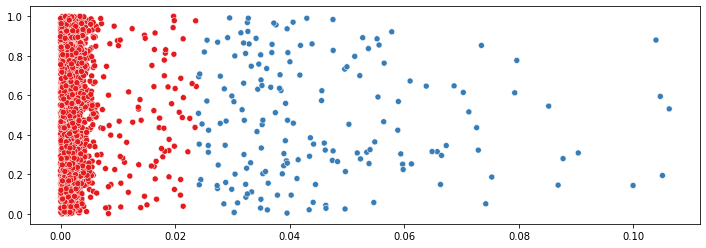

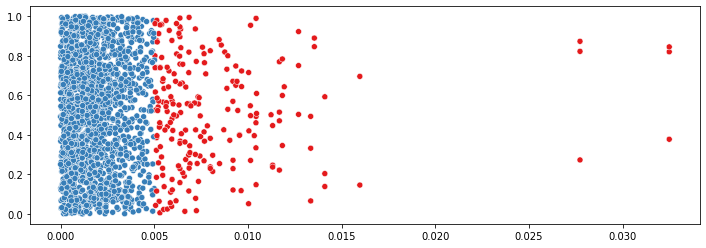

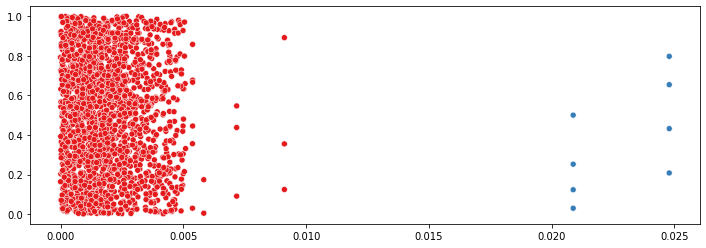

0.10197997287702736

In [4]:
spectral = SpectralClustering(n_clusters=2)
X_clean = sample.X.values.copy()
for i in range(4):
    X_clean = clustering(X_clean)
mean_squared_error(sample.Truth, X_clean, squared=False)

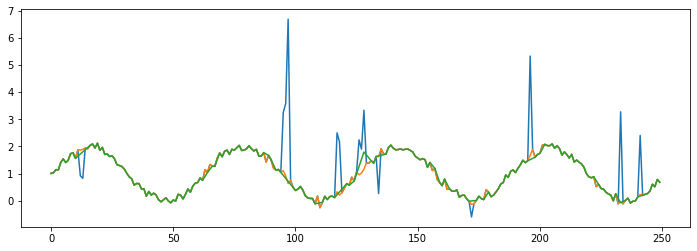

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(sample.X[:250])
plt.plot(sample.Truth[:250])
plt.plot(X_clean[:250])
plt.show()

In [6]:
def spectral_clustering(X):
    X_clean = X.copy()
    for i in range(4):
        X_normed = X_clean / np.linalg.norm(X_clean)
        X_diff = np.concatenate(([0], (X_normed[1:]) - X_normed[:-1]))
        spectral.fit(np.reshape(np.abs(X_diff).tolist(), (X_diff.shape[0], 1)))
        clusters = np.unique(spectral.labels_, return_counts=True)
        largest_cluster = clusters[0][np.argmax(clusters[1])]
        X_clean[np.argwhere(spectral.labels_ != largest_cluster)] = None
        X_clean = pd.Series(X_clean).interpolate().values.copy()
    return X_clean

In [7]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = spectral_clustering(X)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [8]:
report_spectral = run_tests('../data/')
report_spectral

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.11049928566213715
File:  ../data/sample2.csv
RMSE:  0.09744489881903173
File:  ../data/sample3.csv
RMSE:  0.1016178700856435
File:  ../data/sample4.csv
RMSE:  0.11750871118365315
File:  ../data/sample5.csv
RMSE:  0.2081015918488405
File:  ../data/sample6.csv
RMSE:  1.3026739528404532
File:  ../data/sample7.csv
RMSE:  4.625445492170831
File:  ../data/sample8.csv
RMSE:  0.5199175084009596
File:  ../data/sample9.csv
RMSE:  109.26220804238426


Sample        RMSE
0  ../data/sample1.csv    0.110499
1  ../data/sample2.csv    0.097445
2  ../data/sample3.csv    0.101618
3  ../data/sample4.csv    0.117509
4  ../data/sample5.csv    0.208102
5  ../data/sample6.csv    1.302674
6  ../data/sample7.csv    4.625445
7  ../data/sample8.csv    0.519918
8  ../data/sample9.csv  109.262208

In [9]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['Neighbors\' difference', 'Spectral clustering'] + list(report_spectral['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3  \
Data preparation      Model                                               
Neighbors' difference Spectral clustering  0.110499  0.097445  0.101618   

                                            sample4   sample5   sample6  \
Data preparation      Model                                               
Neighbors' difference Spectral clustering  0.117509  0.208102  1.302674   

                                            sample7   sample8     sample9  
Data preparation      Model                                                
Neighbors' difference Spectral clustering  4.625445  0.519918  109.262208

In [10]:
board.iloc[[0], :].to_csv('../results/neigh_diff_spectral.csv')